In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("/home/ventsi/Work/mpl-supermongo/supermongo.mplstyle")

from astropy.io import fits
import astropy.units as u
from photutils import aperture_photometry, CircularAperture, CircularAnnulus

import os

In [2]:
# Apertures:
positions = [(153.7, 177.8), (397, 320.3)] # TCrB, #stA
apertures = CircularAperture(positions, r=7.)
annulus = CircularAnnulus(positions, r_in=13., r_out=19.)
phot_apertures = [apertures, annulus]

In [3]:
supported_extensions = [".fit", ".fits"]

containing_directory = "/home/ventsi/Work/TCrB/TCrB_final_data_selected/20160403_ubv_sh/v_ptr/aligned"

if os.path.isdir(containing_directory):
    files = os.listdir(containing_directory)
    sorted_files = sorted(files)
    
    column_names = ["TCrB sum", "stA sum"]
    mag_table = pd.DataFrame(columns=column_names)
    
    for file_name in sorted_files:
        extension = os.path.splitext(file_name)[1].lower()
        if extension not in supported_extensions:
            continue
        
        hdulist = fits.open(file_name)
        data = hdulist[0].data.astype(float)
        header = hdulist[0].header

        phot_table = aperture_photometry(data, phot_apertures)
        for col in phot_table.colnames:
            phot_table[col].info.format = "%.8g" # for consistent table output

        background_mean = phot_table["aperture_sum_1"] / annulus.area()

        background_local = background_mean * apertures.area()
        sum_minus_background = phot_table["aperture_sum_0"] - background_local
        phot_table["residual_aperture_sum"] = sum_minus_background

        mag_table = mag_table.append({"TCrB sum": phot_table["residual_aperture_sum"][0], "stA sum": phot_table["residual_aperture_sum"][1]}, ignore_index=True)

In [4]:
mag_table.head()

,TCrB sum,stA sum
0,167433.267662,27598.784016
1,166047.014042,27210.622413
2,163730.156354,27239.698320
3,164669.220140,27813.143169
4,164352.228057,27225.930932


In [5]:
mag_table["TCrB sum"] = mag_table["TCrB sum"].astype(float)
mag_table["stA sum"] = mag_table["stA sum"].astype(float)

In [6]:
mag_table["TCrB inst"] = 25 + -2.5 * np.log10(mag_table["TCrB sum"])
mag_table["stA inst"] = 25 + -2.5 * np.log10(mag_table["stA sum"])

In [7]:
mag_table.head()

,TCrB sum,stA sum,TCrB inst,stA inst
0,167433.267662,27598.784016,11.940396,13.897775
1,166047.014042,27210.622413,11.949422,13.913154
2,163730.156354,27239.698320,11.964678,13.911994
3,164669.220140,27813.143169,11.958469,13.889375
4,164352.228057,27225.930932,11.960561,13.912543


In [8]:
jd = np.genfromtxt("jd.dat", dtype="float", skip_header=0)
mag_table["JD"] = jd

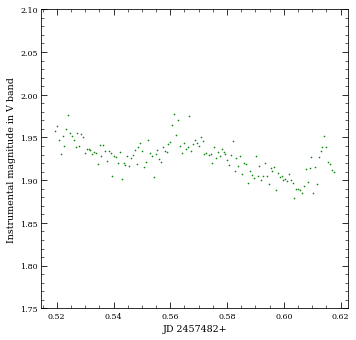

In [9]:
x = mag_table["JD"] - 2457482
y = mag_table["stA inst"] - mag_table["TCrB inst"]

plt.errorbar(x, y, fmt=".", color="green", markersize=1.25, ecolor="green", elinewidth=0.75, capsize=1.25, capthick=0.75)

plt.xlabel("JD 2457482+")
plt.ylabel("Instrumental magnitude in V band")
plt.ylim([2.10, 1.75])
# Reverse Y axis:
plt.gca().invert_yaxis()

plt.show()